In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [106]:
import sys
# /usr/local/anaconda3/bin/python !pip3 install pmdarima
# !{sys.executable} -m pip install pmdarima
import pmdarima as pm

## Load Data

In [2]:
df_prop = pd.read_csv("data/Boston-MLS/boston_property_info.csv")
df_listing = pd.read_csv("data/Boston-MLS/boston_listing_dates.csv")

In [3]:
display(df_prop.head())
display(df_listing.head())

,cc_property_id,data_source,address,city,zipcode,cc_property_address_county,fips,apn,property_guid,latitude,...,below_grade_bed_count,below_grade_sqft,current_use,fencing_description,frontage_length,property_condition,property_quality,senior_community_indicator,zoning_code,zoning_description
0,646169409,dataharmony,148 Main St,Barre,1005,WORCESTER,25027.0,3643754,NaN,42.38276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,70050770,dataharmony,545 Old Dana Rd,Barre,1005,WORCESTER,25027.0,3642279,NaN,42.42725,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R80,NaN
2,687359619,dataharmony,15 Church St 17,Barre,1005,WORCESTER,25027.0,3644007,NaN,42.38500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MF,NaN
3,687358797,dataharmony,26 Trafalgar Sq,Barre,1005,WORCESTER,25027.0,3643996,NaN,42.38417,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN
4,570107982,dataharmony,116 Oakham Rd,Barre,1005,WORCESTER,25027.0,3643461,NaN,42.37477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1010,NaN


,property_id,zipcode,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price
0,68560382,1880,2016-03-01,2016-04-13,NaN,NaN,NaN,Sale,485000.0
1,504929421,1440,2016-03-01,NaN,NaN,NaN,2016-05-02,Cancelled,NaN
2,347490903,2130,2016-03-01,2016-04-22,NaN,NaN,NaN,Sale,772000.0
3,66726260,2720,2016-03-01,2016-05-18,NaN,NaN,NaN,Sale,137194.0
4,645765969,2301,2016-03-01,2016-07-08,NaN,NaN,NaN,Sale,405000.0


In [6]:
df = pd.merge(df_prop, df_listing.drop("zipcode", axis=1), left_on="cc_property_id", right_on="property_id", how="inner")
# df.to_csv("data/property_listings.csv")

In [7]:
df.zipcode = df.zipcode.astype("str")

## EDA: Distribution per City, Zipcode

In [253]:
df_listing = df.groupby(["zipcode", "list_date"]).agg({"property_id":"count"}).reset_index()
df_listing["zipcode"] = "0"+df_listing["zipcode"]
df_listing["list_month"] = df_listing.list_date.apply(lambda x :x[:-3])
df_listing = df_listing.rename(columns={"property_id":"count_listing"})

In [164]:
df_sale = df.groupby(["zipcode", "sale_date"]).agg({"property_id":"count", "sale_price":"sum"}).reset_index()
df_sale["zipcode"] = "0"+df_sale["zipcode"]
df_sale["sale_month"] = df_sale.sale_date.apply(lambda x :x[:-3])
df_sale = df_sale.rename(columns={"property_id":"count_sale", "sale_price":"total_value"})

In [97]:
top10sales = list(df_sale.groupby("zipcode").sum().sort_values("total_value", ascending=False).head(10).reset_index().zipcode)
top10unitSold = list(df_sale.groupby("zipcode").sum().sort_values("count_sale", ascending=False).head(10).reset_index().zipcode)

df_sale_monthly = df_sale.groupby(["sale_month", "zipcode"]).agg({"count_sale":"sum", "total_value":"sum"}).reset_index()


In [98]:
df_sale_monthly = df_sale_monthly.sort_values("total_value", ascending=False)
df_sale_monthly.head()

,sale_month,zipcode,count_sale,total_value
12124,2019-06,02210,50,134151867.0
4665,2017-06,02116,49,116653388.0
8563,2018-07,02127,128,112848100.0
1059,2016-06,02118,71,93785838.0
16271,2020-07,02127,87,87530955.0


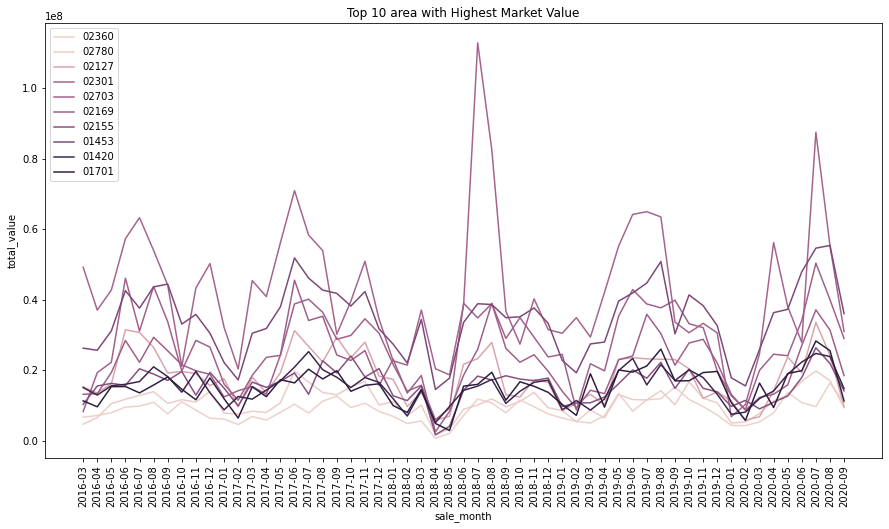

In [114]:
df_sale_monthly["zipcode"] = df_sale_monthly["zipcode"].astype(str)

plt.figure(figsize=(15,8))
sns.lineplot(x="sale_month", hue="zipcode", y="total_value", data=df_sale_monthly[df_sale_monthly["zipcode"].isin(top10unitSold)], ci=None)
plt.xticks(rotation=90)
plt.legend(top10unitSold)
plt.title("Top 10 area with Highest Market Value")
plt.show()


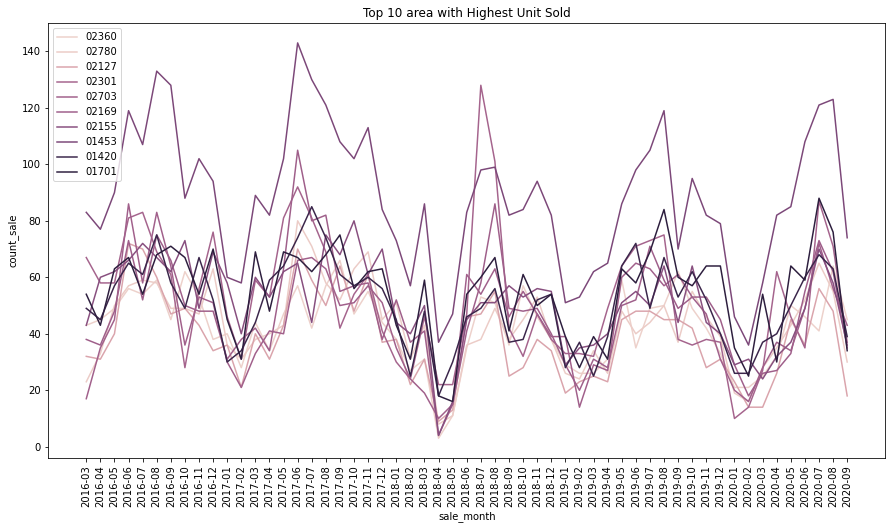

In [115]:
plt.figure(figsize=(15,8))
sns.lineplot(x="sale_month", hue="zipcode",y="count_sale", data=df_sale_monthly[df_sale_monthly["zipcode"].isin(top10unitSold)], ci=None)
plt.xticks(rotation=90)
plt.legend(top10unitSold)
plt.title("Top 10 area with Highest Unit Sold")
plt.show()

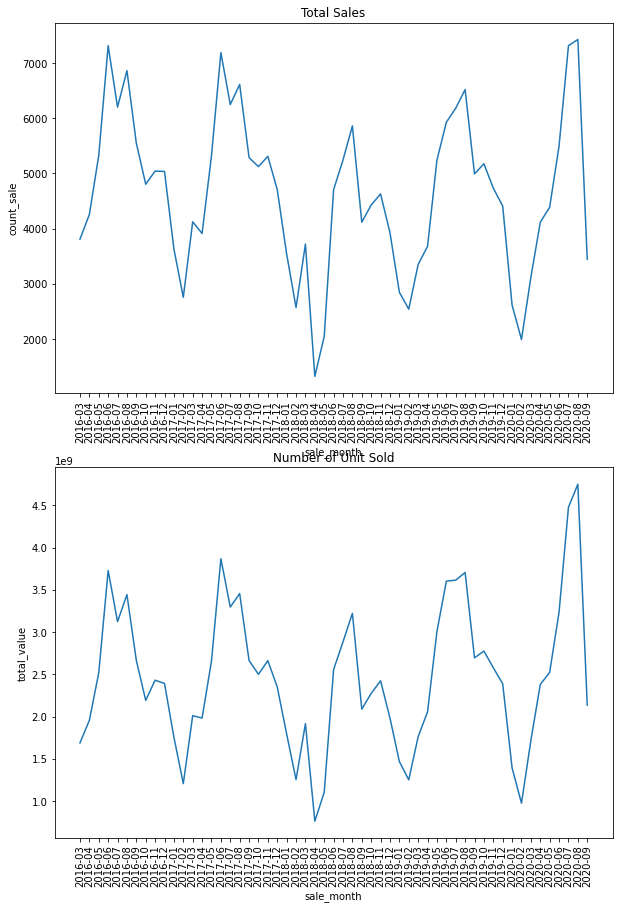

In [227]:
fig, ax = plt.subplots(2,1,figsize=(10,15))
sns.lineplot(x="sale_month",y="count_sale", data=df_sale_agg, ci=None, ax=ax[0])
ax[0].set_xticklabels(df_sale_agg.sale_month, rotation=90)
ax[0].set_title("Total Sales")

sns.lineplot(x="sale_month",y="total_value", data=df_sale_agg, ci=None, ax=ax[1])
ax[1].set_xticklabels(df_sale_agg.sale_month, rotation=90)
ax[1].set_title("Number of Unit Sold")

plt.show()

## EDA


### 1. Relationship with Population Density

In [279]:
# https://www.massachusetts-demographics.com/zip_codes_by_population
df_demographic = pd.read_csv("data/MA_population.csv")

df_demographic['Population'] = df_demographic['Population'].str.replace(",","").astype(int)
df_demographic["Zip Code"] = "0"+df_demographic["Zip Code"].astype(str)

# df_sale_population = pd.merge(df_sale, df_demographic[["Zip Code", "Population"]], 
#                               left_on="zipcode", right_on="Zip Code")
# df_sale_population.drop("Zip Code", axis=1, inplace=True)

# scaler = MinMaxScaler()
# normalized_pop = scaler.fit_transform(df_sale_population["Population"].values.reshape(-1, 1))
# df_sale_population["normalized_population"] = normalized_pop.flatten()

df_sale_listing_monthly = df_sale.groupby(['sale_month', 'zipcode']).sum()[['count_sale', 'total_value']].reset_index()
df_sale_listing_monthly = pd.merge(df_sale_listing_monthly, df_listing.groupby('list_month').sum()['count_listing'],
                                   left_on='sale_month', right_index=True)
df_sale_listing_monthly = pd.merge(df_sale_listing_monthly, df_demographic[["Zip Code", "Population"]], 
                                   left_on="zipcode", right_on="Zip Code")

dist = df_sale_listing_monthly.groupby(["zipcode","Population"]).sum()[["count_sale", "count_listing"]].reset_index()

# remove outliers (small cities with low population and very small # sales)
dist_filtered = dist[(dist["count_sale"] >= np.percentile(dist["count_sale"], 10)) & 
                     (dist["Population"] >= np.percentile(dist["Population"], 2.5))]

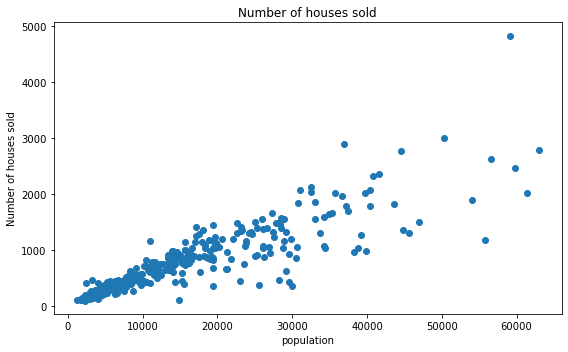

In [293]:
# remove outliers
# fig, ax = plt.subplots(2,1,figsize=(10,15))
plt.figure(figsize=(8,5))
fig.suptitle("Relationship of Population Density vs Real Estate Sales", y=1.05,fontsize=15)
plt.scatter(dist_filtered["Population"], dist_filtered["count_sale"])
plt.title("Number of houses sold")
plt.xlabel("population")
plt.ylabel("Number of houses sold")
# ax[1].scatter(dist_filtered["Population"], dist_filtered["count_listing"])
# ax[1].set_title("Total transaction value")
# ax[1].set_ylabel("Total transaction value")
# ax[1].set_xlabel("population")

plt.tight_layout()

In [296]:
df_sale_listing_monthly["count_sale_normalized"] = df_sale_listing_monthly['count_sale']/df_sale_listing_monthly['Population']
df_sale_listing_monthly["total_sale_normalized"] = df_sale_listing_monthly['total_value']/df_sale_listing_monthly['Population']
df_sale_listing_monthly                                                                                                    
                                                                                                                 

,sale_month,zipcode,count_sale,total_value,count_listing,Zip Code,Population,count_sale_normalized,total_sale_normalized
0,2016-03,01005,1,85000.0,20204,01005,4991,0.000200,17.030655
1,2016-04,01005,6,900400.0,12414,01005,4991,0.001202,180.404729
2,2016-05,01005,5,705000.0,9850,01005,4991,0.001002,141.254258
3,2016-06,01005,6,1532000.0,9035,01005,4991,0.001202,306.952515
4,2016-07,01005,6,1240400.0,6646,01005,4991,0.001202,248.527349
...,...,...,...,...,...,...,...,...,...
16857,2020-07,02650,4,4593500.0,14370,02650,845,0.004734,5436.094675
16858,2020-08,02650,3,4650000.0,13203,02650,845,0.003550,5502.958580
16859,2020-09,02650,1,420000.0,12172,02650,845,0.001183,497.041420
16860,2019-06,01074,1,56000.0,23622,01074,548,0.001825,102.189781


### 1. Relationship with Google Trends Data

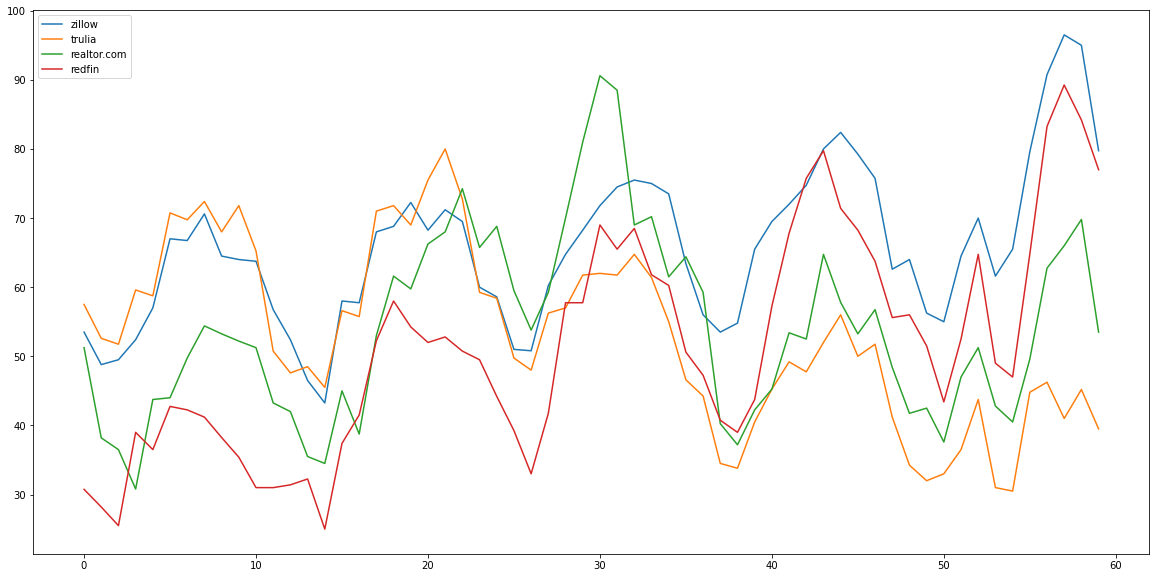

In [195]:
# cd DigitalRealEstateIndex/google_trends
keyword_to_time_series = np.load('googltrends.npy',allow_pickle='TRUE').item()
plt.figure(figsize=(20, 10))
for keyword, time_series in keyword_to_time_series.items():
    plt.plot(time_series, label=keyword)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Google Trends data for Massachusets')

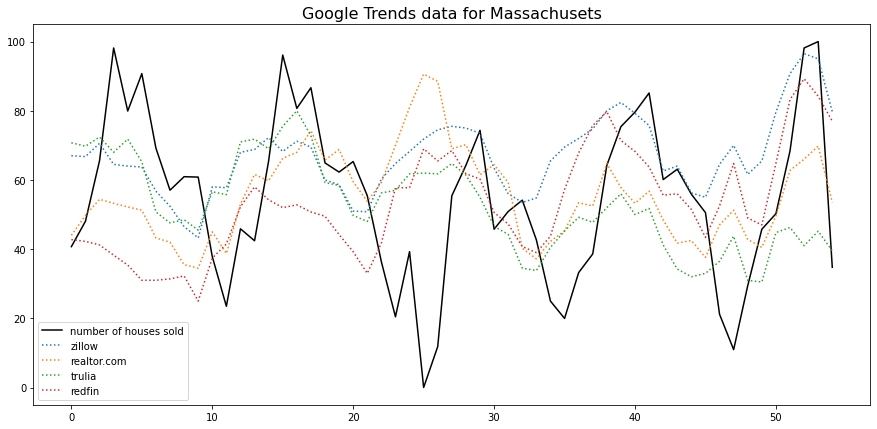

In [311]:
df_sale_agg = df_sale_monthly.groupby('sale_month').sum()[['count_sale', 'total_value']].reset_index()
df_sale_googletrends = df_sale_agg.copy()
n = len(df_sale_googletrends)
for keyword, time_series in keyword_to_time_series.items():
    df_sale_googletrends[keyword] = time_series[-n:]
    
df_sale_googletrends["total_value_normalized"] = MinMaxScaler((0,100)).fit_transform(df_sale_googletrends.total_value.values.reshape(-1, 1))
df_sale_googletrends["count_sale_normalized"] = MinMaxScaler((0,100)).fit_transform(df_sale_googletrends.count_sale.values.reshape(-1, 1))


plt.figure(figsize=(15, 7))
# plt.plot(df_sale_googletrends["total_value_normalized"], c="k", linewidth=2, label="total transaction value")
plt.plot(df_sale_googletrends["count_sale_normalized"], c="black",  label="number of houses sold")
for series in ['zillow', 'realtor.com', 'trulia', 'redfin']:
    time_series = df_sale_googletrends[series]
    plt.plot(time_series, label=series, linestyle=":")
# plt.xticks(np.arange(len(time_series)),labels=df_sale_googletrends.sale_month.values, rotation=90)
plt.legend()
plt.title("Google Trends data for Massachusets", fontsize=16)



## Baseline Forecast per city, zipcode

### 1. Forecast for Market Value (Total Dollar Price of all Transaction)¶

 ARIMA(0,0,0)(0,0,1)[12] intercept
 ARIMA(2,0,2)(2,0,0)[12] intercept
 ARIMA(1,0,0)(0,0,2)[12] intercept
 ARIMA(0,0,1)(0,0,1)[12] intercept
 ARIMA(1,0,0)(2,0,1)[12] intercept
 ARIMA(0,0,2)(0,0,2)[12] intercept
 ARIMA(1,0,0)(1,0,0)[12] intercept
 ARIMA(1,0,0)(1,0,0)[12] intercept
 ARIMA(1,0,0)(0,0,0)[12] intercept
 ARIMA(1,0,0)(0,0,1)[12] intercept


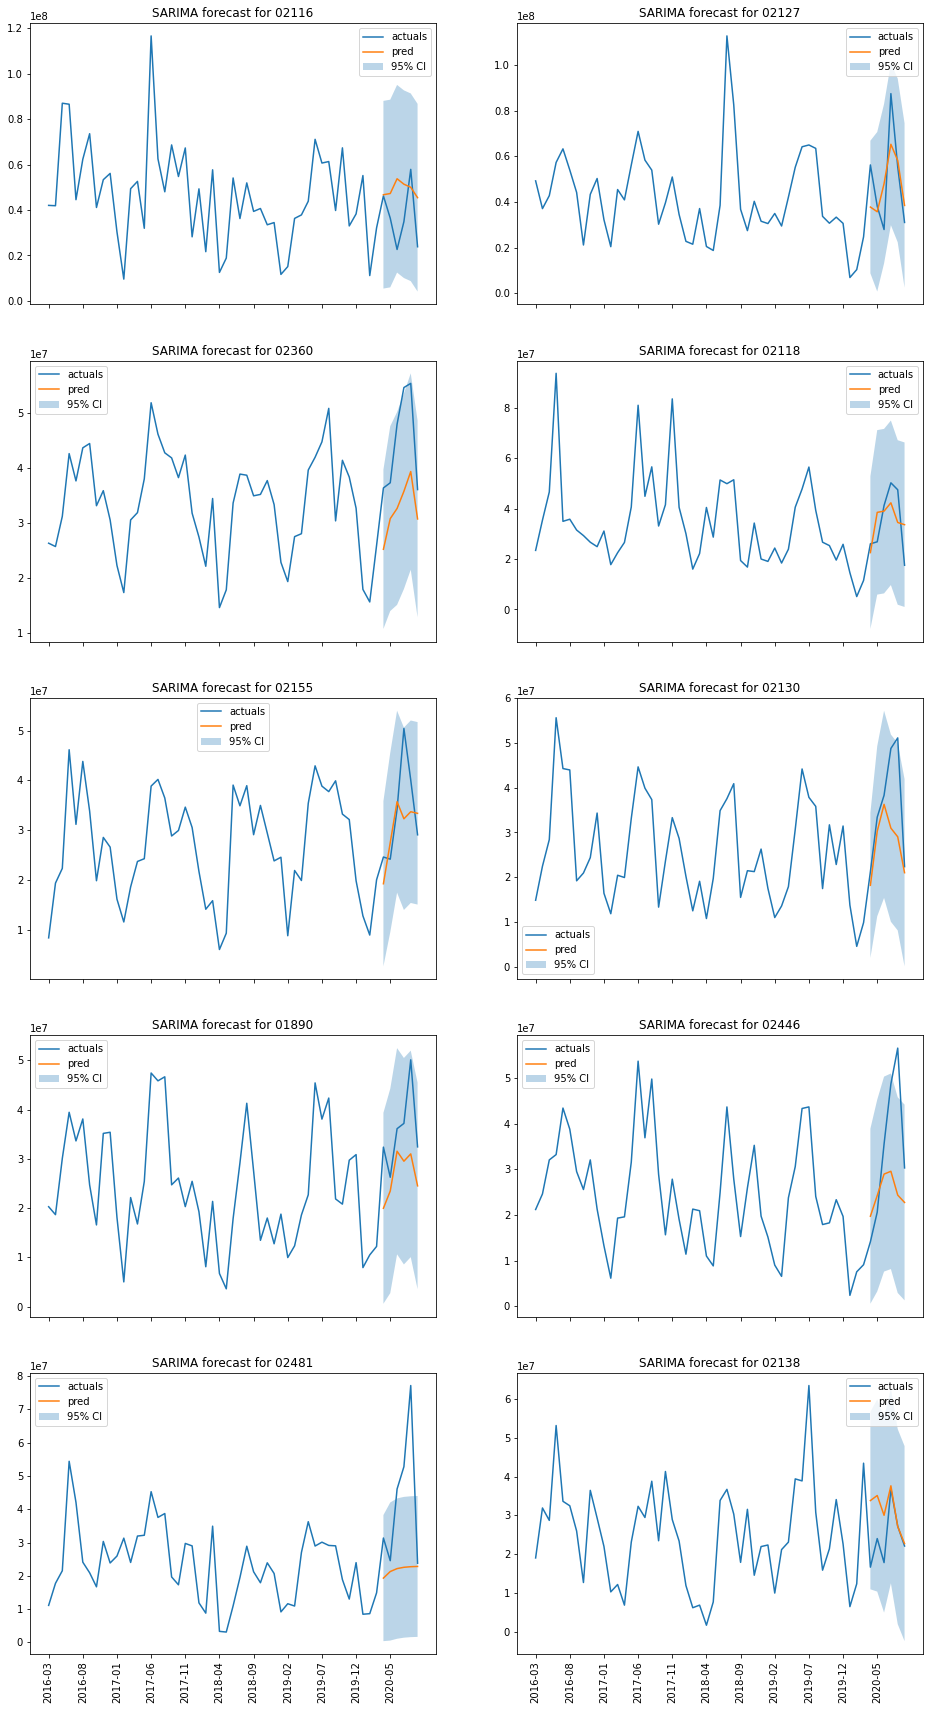

In [107]:
n_periods = 6
fig, ax = plt.subplots(5,2,sharex=True, figsize=(16,30))
for idx, area in enumerate(top10sales):
    model=pm.auto_arima(df_sale_monthly[df_sale_monthly["zipcode"]==area].sort_values("sale_month")["total_value"][:-n_periods], 
                  seasonal=True, m=12)
    print(model)

    pred, CI = model.predict(6, return_conf_int=True)
    df_plot = df_sale_monthly[df_sale_monthly["zipcode"]==area].sort_values("sale_month")

    ax[idx//2, idx%2].plot(range(len(df_plot)), df_plot["total_value"], label="actuals")
    ax[idx//2, idx%2].plot(range(len(df_plot)-n_periods,len(df_plot)), pred, label="pred")
    ax[idx//2, idx%2].fill_between(range(len(df_plot)-n_periods,len(df_plot)),CI[:,0], CI[:,1], alpha=0.3, label=("95% CI"))
    ax[idx//2, idx%2].set_xticks(range(len(df_plot))[::5])
    ax[idx//2, idx%2].set_xticklabels(df_plot.sale_month[::5], rotation=90)
    ax[idx//2, idx%2].set_title("SARIMA forecast for "+area)
    ax[idx//2, idx%2].legend()
    
    

### 2. Forecast for Number of Units Sold¶

 ARIMA(1,0,0)(1,0,0)[12] intercept
 ARIMA(0,0,1)(1,0,1)[12] intercept
 ARIMA(0,0,1)(2,0,0)[12] intercept
 ARIMA(0,1,1)(1,0,0)[12]          
 ARIMA(1,0,0)(2,0,0)[12] intercept
 ARIMA(1,0,0)(1,0,0)[12] intercept
 ARIMA(1,0,0)(1,0,1)[12] intercept
 ARIMA(1,0,0)(0,0,1)[12] intercept
 ARIMA(1,0,0)(0,0,0)[12] intercept
 ARIMA(1,0,0)(1,0,1)[12] intercept


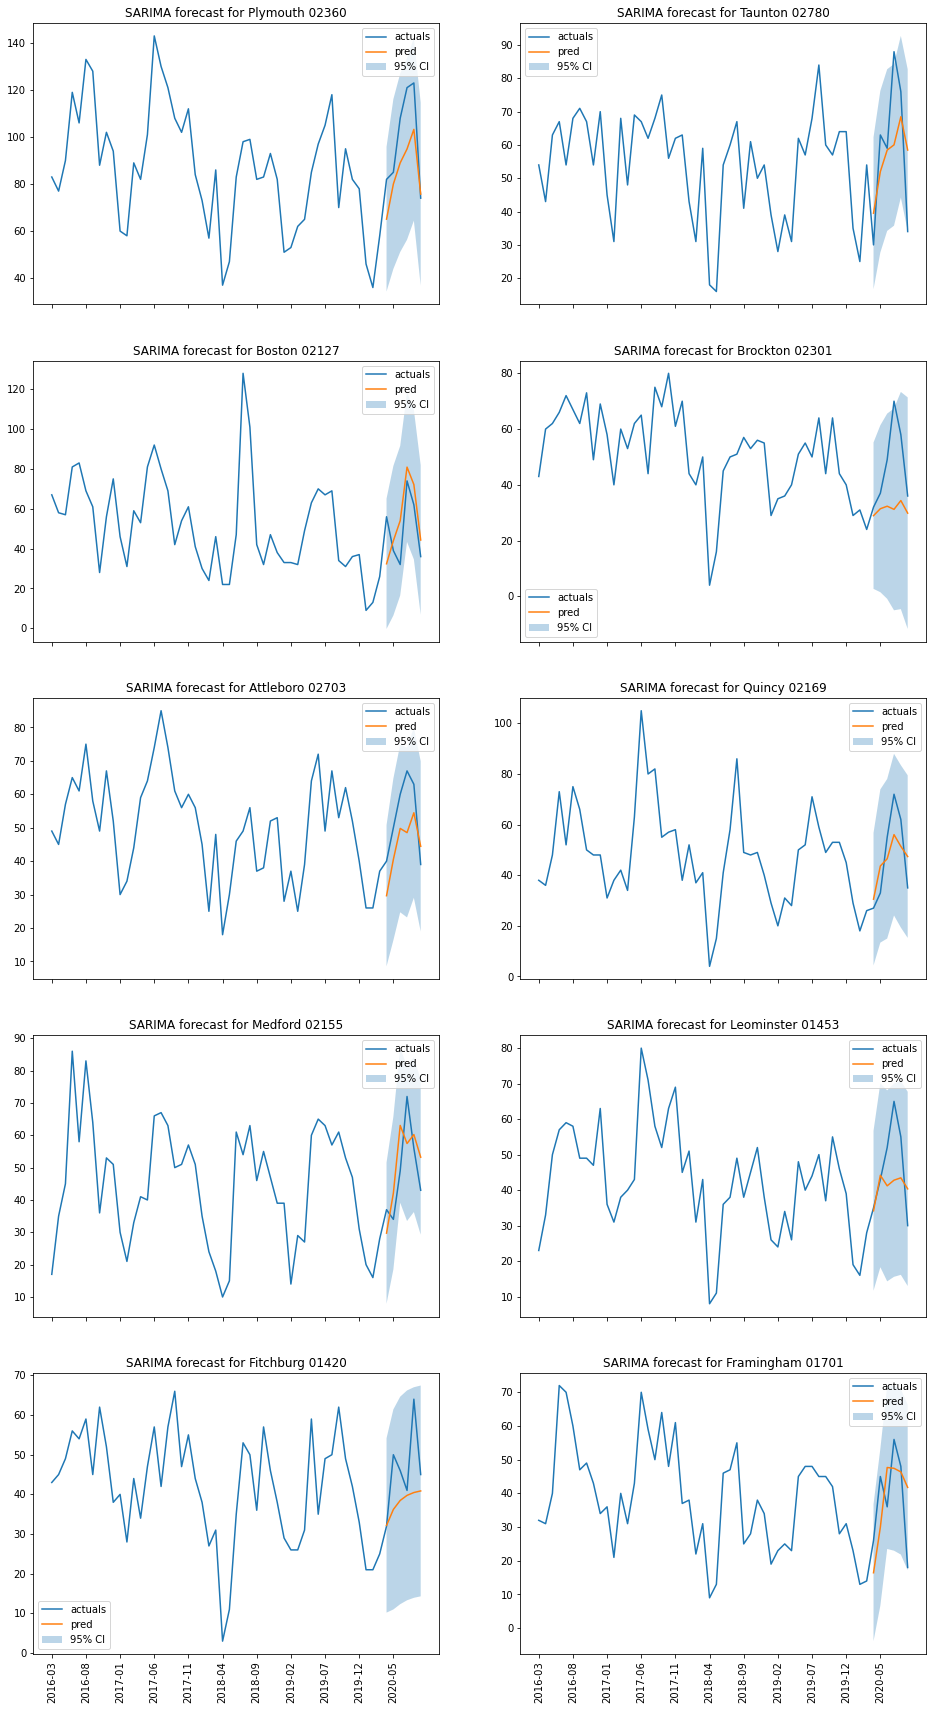

In [290]:
n_periods = 6
fig, ax = plt.subplots(5,2,sharex=True, figsize=(16,30))
for idx, area in enumerate(top10unitSold):
    model=pm.auto_arima(df_sale_monthly[df_sale_monthly["city_zip"]==area].sort_values("sale_month")["count_sale"][:-n_periods], 
                  seasonal=True, m=12)
    print(model)

    pred, CI = model.predict(6, return_conf_int=True)
    df_plot = df_sale_monthly[df_sale_monthly["city_zip"]==area].sort_values("sale_month")

    ax[idx//2, idx%2].plot(range(len(df_plot)), df_plot["count_sale"], label="actuals")
    ax[idx//2, idx%2].plot(range(len(df_plot)-n_periods,len(df_plot)), pred, label="pred")
    ax[idx//2, idx%2].fill_between(range(len(df_plot)-n_periods,len(df_plot)),CI[:,0], CI[:,1], alpha=0.3, label=("95% CI"))
    ax[idx//2, idx%2].set_xticks(range(len(df_plot))[::5])
    ax[idx//2, idx%2].set_xticklabels(df_plot.sale_month[::5], rotation=90)
    ax[idx//2, idx%2].set_title("SARIMA forecast for "+area)
    ax[idx//2, idx%2].legend()
    

## Baseline Forecast by County

In [166]:
zip_county_mapping = pd.read_csv("data/zip_county.csv")
zip_county_mapping["Zip Code"] = "0"+zip_county_mapping["Zip Code"].astype("str")

df_sale = pd.merge(df_sale, zip_county_mapping[["Zip Code", "County"]], 
                              left_on="zipcode", right_on="Zip Code")
df_sale.drop("Zip Code", axis=1, inplace=True)

df_sale_county_monthly = df_sale.groupby(["sale_month", "County"]).agg({"count_sale":"sum", "total_value":"sum"}).reset_index()
df_sale_county_monthly = df_sale_county_monthly.sort_values("total_value", ascending=False)
df_sale_county_monthly.head()


,sale_month,County,count_sale,total_value
373,2020-08,Middlesex,2168,1.670760e+09
366,2020-07,Middlesex,2176,1.619976e+09
23,2016-06,Middlesex,2461,1.500166e+09
107,2017-06,Middlesex,2247,1.410881e+09
37,2016-08,Middlesex,2316,1.391852e+09


### 1. Forecast for Market Value (Total Dollar Price of all Transaction)¶

 ARIMA(1,0,3)(1,0,0)[12] intercept
 ARIMA(2,0,0)(0,0,1)[12] intercept
 ARIMA(2,0,1)(1,0,0)[12] intercept
 ARIMA(1,0,0)(0,0,2)[12] intercept
 ARIMA(1,0,2)(1,0,0)[12] intercept
 ARIMA(1,0,0)(0,1,1)[12] intercept
 ARIMA(1,0,0)(0,0,1)[12] intercept


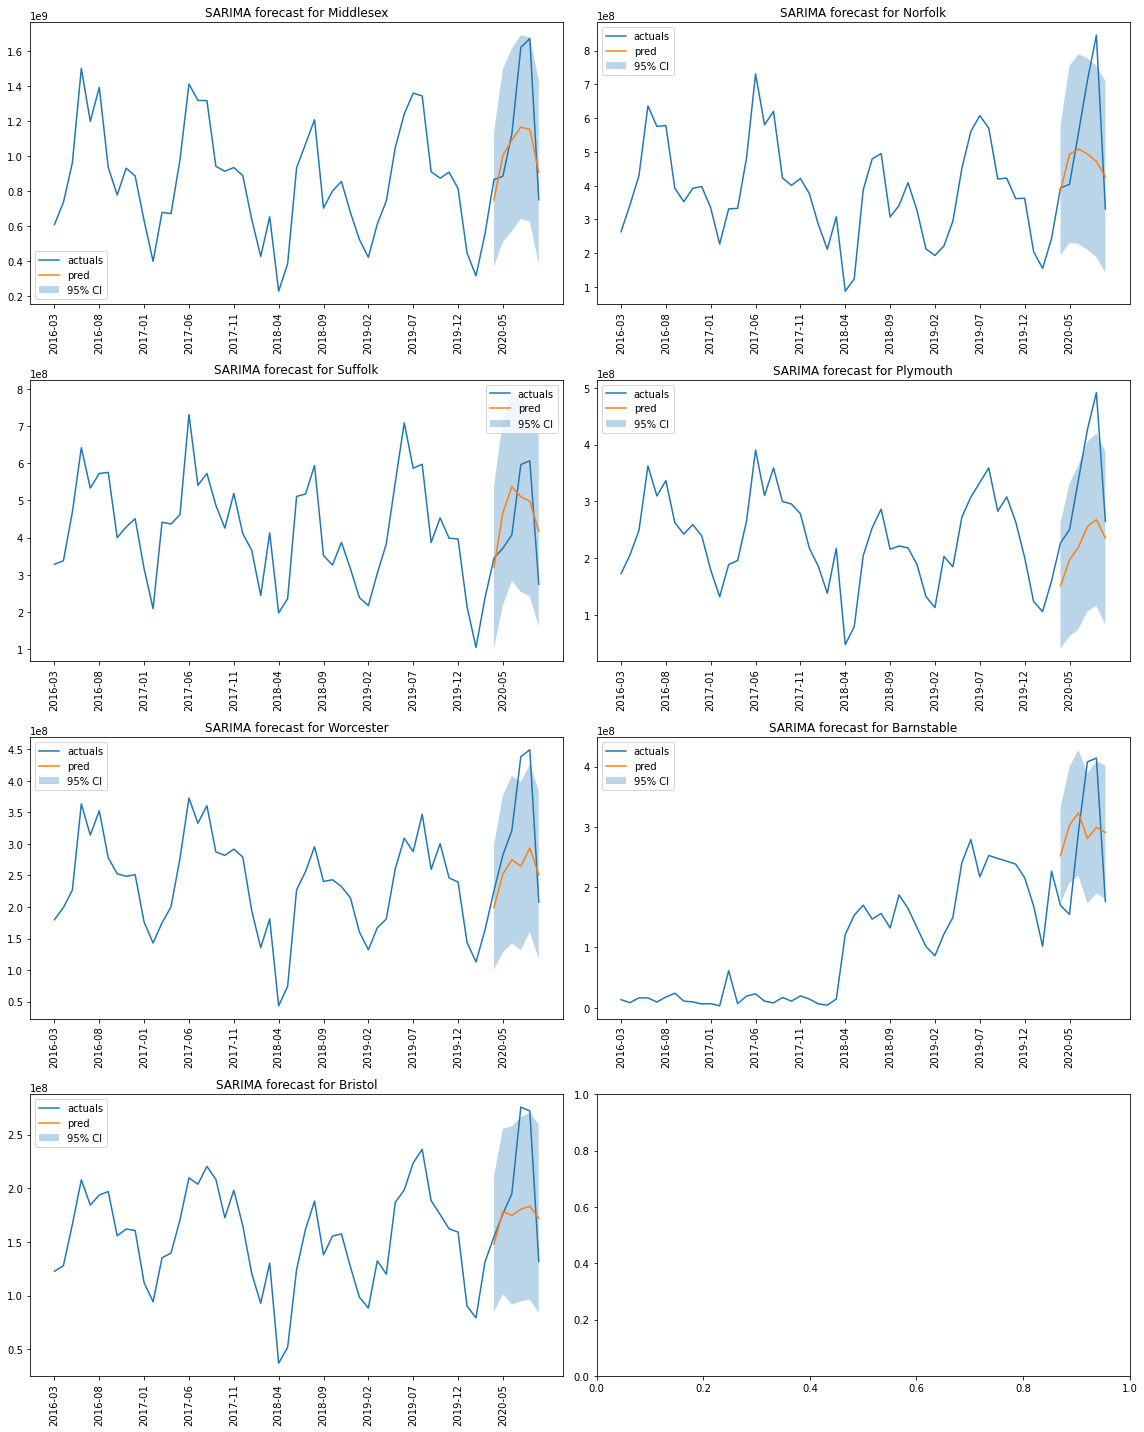

In [172]:
n_periods = 6
fig, ax = plt.subplots(4,2,figsize=(16,20))
for idx, area in enumerate(df_sale_county_monthly.County.unique()):
    model=pm.auto_arima(df_sale_county_monthly[df_sale_county_monthly["County"]==area].sort_values("sale_month")["total_value"][:-n_periods], 
                  seasonal=True, m=12)
    print(model)

    pred, CI = model.predict(6, return_conf_int=True)
    df_plot = df_sale_county_monthly[df_sale_county_monthly["County"]==area].sort_values("sale_month")

    ax[idx//2, idx%2].plot(range(len(df_plot)), df_plot["total_value"], label="actuals")
    ax[idx//2, idx%2].plot(range(len(df_plot)-n_periods,len(df_plot)), pred, label="pred")
    ax[idx//2, idx%2].fill_between(range(len(df_plot)-n_periods,len(df_plot)),CI[:,0], CI[:,1], alpha=0.3, label=("95% CI"))
    ax[idx//2, idx%2].set_xticks(range(len(df_plot))[::5])
    ax[idx//2, idx%2].set_xticklabels(df_plot.sale_month.unique()[::5], rotation=90)
    ax[idx//2, idx%2].set_title("SARIMA forecast for "+area)
    ax[idx//2, idx%2].legend()
plt.tight_layout()

### 2. Forecast for Number of Units Sold

 ARIMA(1,0,0)(2,0,0)[12] intercept
 ARIMA(1,0,0)(1,0,1)[12] intercept
 ARIMA(1,0,0)(1,0,0)[12] intercept
 ARIMA(1,0,0)(1,0,1)[12] intercept
 ARIMA(1,0,0)(1,0,1)[12] intercept
 ARIMA(0,1,0)(0,0,0)[12]          
 ARIMA(1,0,0)(1,0,1)[12] intercept


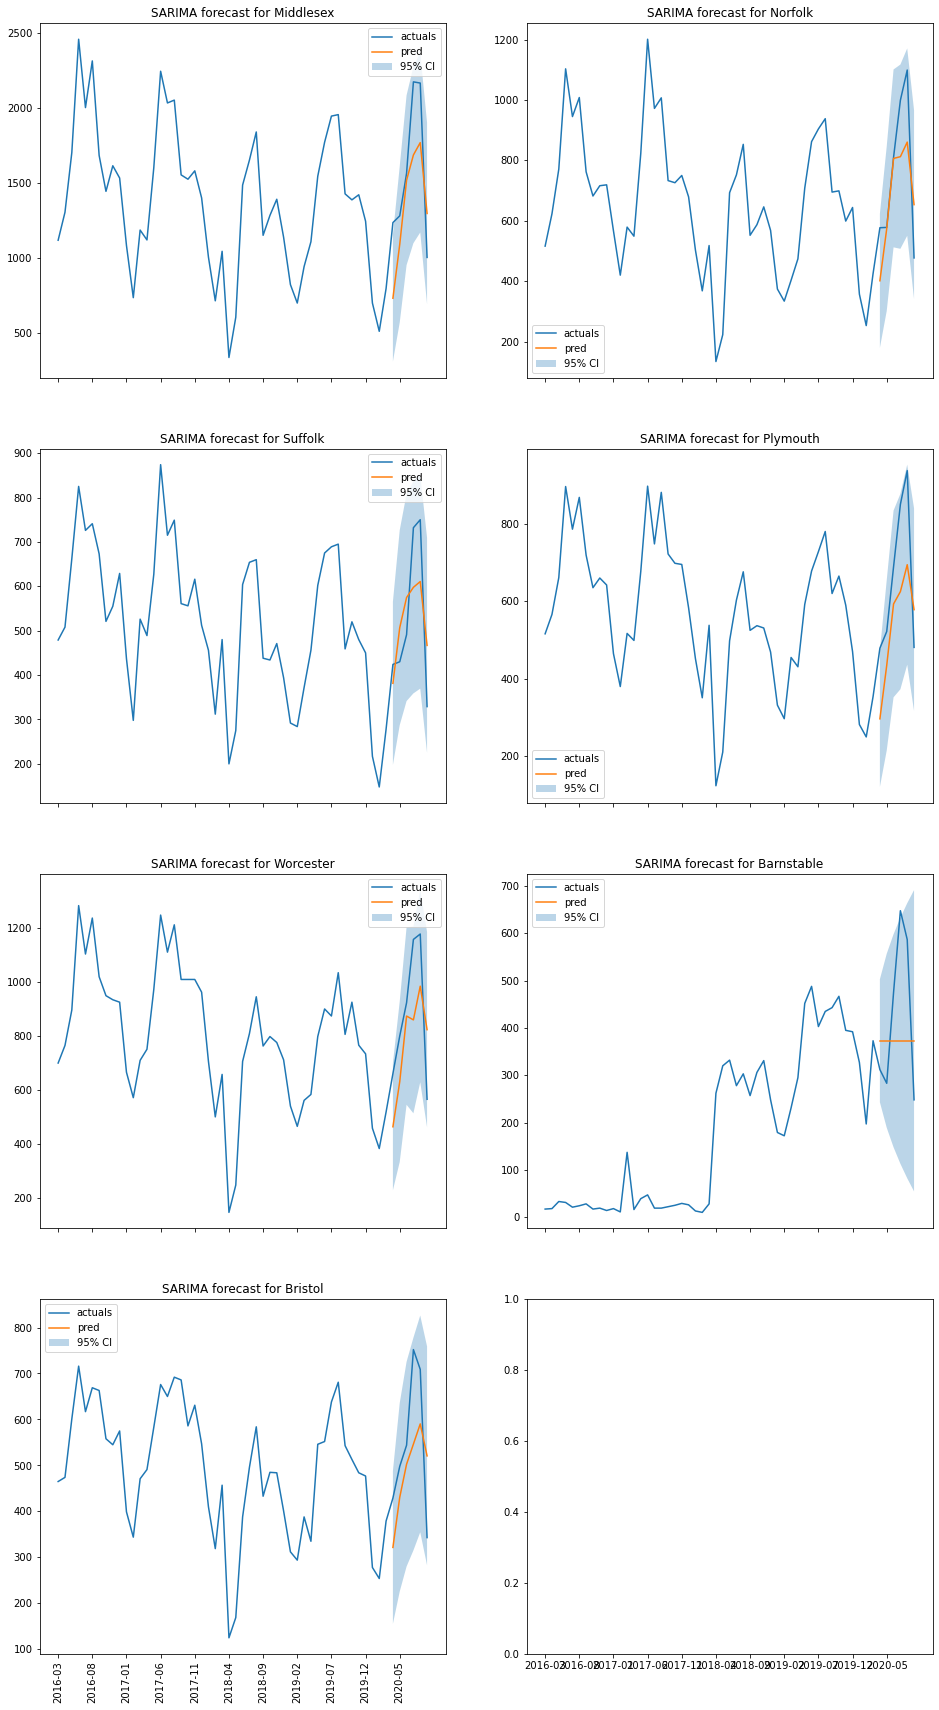

In [175]:
n_periods = 6
fig, ax = plt.subplots(4,2,sharex=True, figsize=(16,30))
for idx, area in enumerate(df_sale_county_monthly.County.unique()):
    model=pm.auto_arima(df_sale_county_monthly[df_sale_county_monthly["County"]==area].sort_values("sale_month")["count_sale"][:-n_periods], 
                  seasonal=True, m=12)
    print(model)

    pred, CI = model.predict(6, return_conf_int=True)
    df_plot = df_sale_county_monthly[df_sale_county_monthly["County"]==area].sort_values("sale_month")

    ax[idx//2, idx%2].plot(range(len(df_plot)), df_plot["count_sale"], label="actuals")
    ax[idx//2, idx%2].plot(range(len(df_plot)-n_periods,len(df_plot)), pred, label="pred")
    ax[idx//2, idx%2].fill_between(range(len(df_plot)-n_periods,len(df_plot)),CI[:,0], CI[:,1], alpha=0.3, label=("95% CI"))
    ax[idx//2, idx%2].set_xticks(range(len(df_plot))[::5])
    ax[idx//2, idx%2].set_xticklabels(df_plot.sale_month[::5], rotation=90)
    ax[idx//2, idx%2].set_title("SARIMA forecast for "+area)
    ax[idx//2, idx%2].legend()
    